# Binary Classification

## Load Dataset from sklearn

In [3]:
import numpy as np
import  pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import load_breast_cancer
cancer=load_breast_cancer()

In [8]:
df=pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class']=cancer.target

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [9]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'class'],
      dtype='object')

## Convert to PyTorch Tensor

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
data=torch.from_numpy(df.values).float()

data.shape

torch.Size([569, 31])

In [16]:
x=data[:, :10]
y=data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 10]) torch.Size([569, 1])


## Train, Valid, Test set 나누기

In [17]:
# Train/Valid/Test ratio
ratios=[.6, .2, .2]

In [18]:
train_cnt=int(data.size(0)*ratios[0])
valid_cnt=int(data.size(0)*ratios[1])
test_cnt=data.size(0)-train_cnt-valid_cnt
cnts=[train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [19]:
indices=torch.randperm(data.size(0))

x=torch.index_select(x, dim=0, index=indices)
y=torch.index_select(y, dim=0, index=indices)

x=x.split(cnts, dim=0)
y=y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 10]) torch.Size([341, 1])
torch.Size([113, 10]) torch.Size([113, 1])
torch.Size([115, 10]) torch.Size([115, 1])


You don't need to shuffle them, if you have fixed train/valid/test set.

## Set Hyper Parameters

In [39]:
n_epochs=10000
batch_size=128
print_interval=500
early_stop=100

## Get dataLoaders

In [40]:
from torch.utils.data import Dataset, DataLoader

In [41]:
class CustomDataset(Dataset):
    
    def __init__(self, data,labels):
        self.data=data
        self.labels=labels
        
        super().__init__()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [42]:
train_loader = DataLoader(
    dataset=CustomDataset(x[0], y[0]),
    batch_size=batch_size,
    shuffle=True, # Allow shuffling only for training set.
)
valid_loader = DataLoader(
    dataset=CustomDataset(x[1], y[1]),
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    dataset=CustomDataset(x[2], y[2]),
    batch_size=batch_size,
    shuffle=False,
)

print("Train %d / Valid %d / Test %d samples." % (
    len(train_loader.dataset),
    len(valid_loader.dataset),
    len(test_loader.dataset),
))

Train 341 / Valid 113 / Test 115 samples.


## Build Model & Optimizer

In [43]:
model=nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3,y[0].size(-1)),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=10, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
  (9): Sigmoid()
)

In [44]:
optimizer= optim.Adam(model.parameters())

## Train

In [45]:
from copy import deepcopy

lowest_loss=np.inf
best_model=None

lowest_epoch=np.inf

In [46]:
train_history, valid_history=[], []

for i in range(n_epochs):
    model.train()
    
    # We can remove following code block.
    # ------------------------------------------------------
    # indices = torch.randperm(x[0].size(0))
    # x_ = torch.index_select(x[0], dim=0, index=indices)
    # y_ = torch.index_select(y[0], dim=0, index=indices)
    #
    # x_ = x_.split(batch_size, dim=0)
    # y_ = y_.split(batch_size, dim=0)
    # ------------------------------------------------------
    
    train_loss, valid_loss =0, 0
    y_hat=[]
    
    for x_i, y_i in train_loader: #torch.Size([341, 10]) torch.Size([341, 1]), minibatch만큼 train_load 안에 생성이 되어 있음
        y_hat_i=model(x_i)
        loss=F.binary_cross_entropy(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss+=float(loss)  # This is very important to prevent memory leak.
    
    train_loss = train_loss / len(train_loader) #평균적인 train_loss, 미니배치 한 개당 train loss
    
    model.eval()
    with torch.no_grad():
        valid_loss=0
        
        for x_i, y_i in valid_loader:
            y_hat_i=model(x_i)
            loss=F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss+=float(loss)
            
            y_hat+=[y_hat_i] #1 minibatch에 대한 출력값을 모아놓은 것
            
    valid_loss=valid_loss/len(valid_loader) #평균적인 valid_loss, 미니배치 한 개당 valid loss
    
    train_history+=[train_loss] #1 epoch 당 평균 train_loss
    valid_history+=[valid_loss] #1 epoch 당 평균 valid_loss

    if(i+1) % print_interval==0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
    
    if valid_loss<=lowest_loss:
        lowest_loss=valid_loss
        lowest_epoch=i
        
        best_model=deepcopy(model.state_dict())
    else:
        if early_stop>0 and lowest_epoch+early_stop<i+1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)  

Epoch 500: train loss=3.1979e-01  valid_loss=2.8456e-01  lowest_loss=2.8164e-01
Epoch 1000: train loss=2.6796e-01  valid_loss=2.7735e-01  lowest_loss=2.5604e-01
Epoch 1500: train loss=2.5429e-01  valid_loss=2.4611e-01  lowest_loss=2.3940e-01
Epoch 2000: train loss=2.3447e-01  valid_loss=2.1911e-01  lowest_loss=2.1784e-01
Epoch 2500: train loss=1.8603e-01  valid_loss=2.1794e-01  lowest_loss=1.9507e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 2760: 1.9208e-01


<All keys matched successfully>

## Loss History

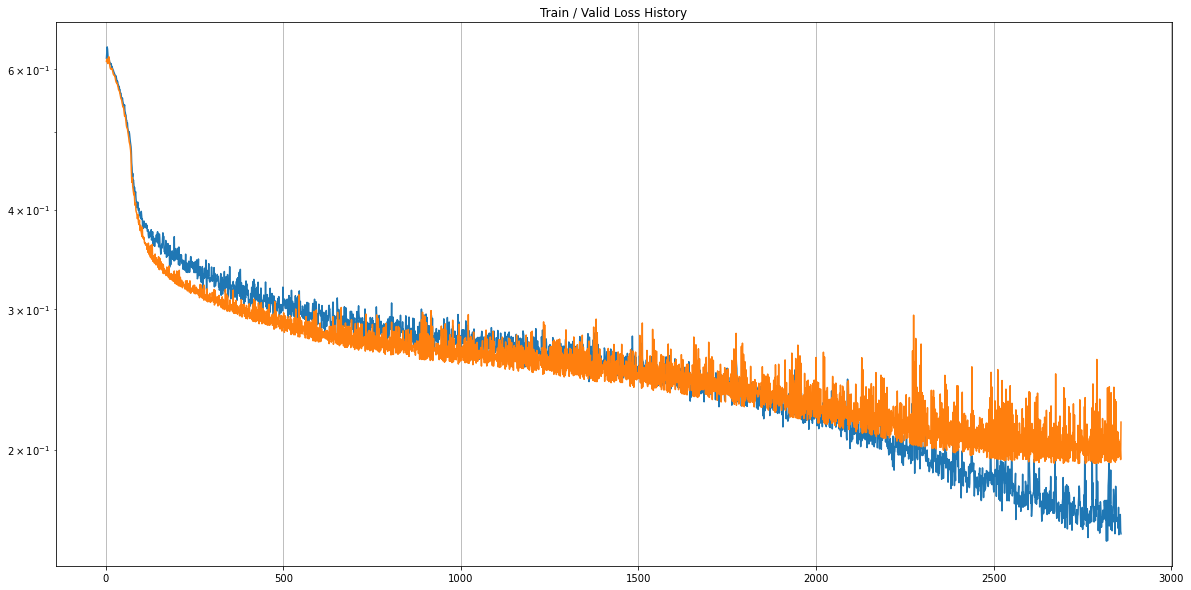

In [47]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [59]:
test_loss=0
y_hat=[]

model.eval()
with torch.no_grad():
    for x_i, y_i in test_loader:
        y_hat_i=model(x_i)
        loss=F.binary_cross_entropy(y_hat_i, y_i)
        
        test_loss+=loss # Gradient is already detached
        
        y_hat+=[y_hat_i]

In [60]:
y_hat[0]

tensor([[9.8568e-01],
        [9.7974e-01],
        [9.8357e-01],
        [1.5056e-05],
        [9.9183e-01],
        [9.8893e-01],
        [2.0908e-04],
        [9.8523e-01],
        [9.0286e-01],
        [8.6352e-03],
        [4.2511e-08],
        [9.7910e-01],
        [9.8680e-01],
        [2.1236e-02],
        [9.9369e-01],
        [9.8175e-01],
        [9.9196e-01],
        [3.1821e-02],
        [9.0648e-01],
        [6.6548e-01],
        [3.9422e-01],
        [2.9805e-04],
        [9.7794e-01],
        [1.5928e-03],
        [9.9123e-01],
        [9.7502e-01],
        [9.3956e-01],
        [1.1076e-08],
        [1.6163e-04],
        [6.9091e-01],
        [8.1093e-01],
        [9.4430e-01],
        [1.1408e-05],
        [7.2880e-01],
        [9.3418e-01],
        [9.7360e-01],
        [9.9186e-01],
        [1.1288e-01],
        [9.1747e-01],
        [9.8011e-01],
        [6.5163e-01],
        [9.6611e-01],
        [8.3416e-01],
        [9.9709e-01],
        [9.6738e-01],
        [9

In [61]:
y_hat[0].shape

torch.Size([115, 1])

In [62]:
test_loss=test_loss/len(test_loader)
y_hat=torch.cat(y_hat, dim=0) #tensor를 합치는 방법으로 여기서는 list+tensor 형태를 tensor로 만들어줌

print("Test loss: %.4e" % test_loss)

Test loss: 1.4887e-01


In [63]:
y_hat

tensor([[9.8568e-01],
        [9.7974e-01],
        [9.8357e-01],
        [1.5056e-05],
        [9.9183e-01],
        [9.8893e-01],
        [2.0908e-04],
        [9.8523e-01],
        [9.0286e-01],
        [8.6352e-03],
        [4.2511e-08],
        [9.7910e-01],
        [9.8680e-01],
        [2.1236e-02],
        [9.9369e-01],
        [9.8175e-01],
        [9.9196e-01],
        [3.1821e-02],
        [9.0648e-01],
        [6.6548e-01],
        [3.9422e-01],
        [2.9805e-04],
        [9.7794e-01],
        [1.5928e-03],
        [9.9123e-01],
        [9.7502e-01],
        [9.3956e-01],
        [1.1076e-08],
        [1.6163e-04],
        [6.9091e-01],
        [8.1093e-01],
        [9.4430e-01],
        [1.1408e-05],
        [7.2880e-01],
        [9.3418e-01],
        [9.7360e-01],
        [9.9186e-01],
        [1.1288e-01],
        [9.1747e-01],
        [9.8011e-01],
        [6.5163e-01],
        [9.6611e-01],
        [8.3416e-01],
        [9.9709e-01],
        [9.6738e-01],
        [9

In [64]:
y_hat.shape

torch.Size([115, 1])

In [65]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))

print('Test Accuracy: %.4f' % (correct_cnt / total_cnt))

Test Accuracy: 0.9565
